# Transformer for Language Translation in PyTorch

In this homework we will try to implement the Transformer for languague translation based on [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper.





Your task will be to define the model for transformer. The code for training and
data processing is already provided. Fill in the code whereever you see the # sign. It is fine if you train the model for just 2 epochs. Training will take a look a lot of time here.

We will refering to this blog post through out this assignment. http://jalammar.github.io/illustrated-transformer/. This is blog post will be refered as the Illustrated transformer blog post.


## Dataset

For the translation task we will use the French-English dataset provided with the zip file. Make sure you extract the zip in the proper location. If the zip file is not extracted in the proper location your code will not work. We tested the code on google collab. You could also try running on it google collab
as well. You will need GPU for this assignment.

In [1]:
import sys
import nltk

# COLAB = True
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/My Drive/Transformer')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Make sure you sure extract the zip in a directory named Transformer. Or change the following depending your directory name

In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torch import nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from fra_eng_dataset import FraEngDataset, fra_eng_dataset_collate
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

## Attention Layers

Please read the section "Self-Attention in Detail" in Illustracted Transformer blog post and the complete the following section.

In [3]:
class SelfAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # K V Q are the matrices for creating the keys, values and queries vector
        self.d_model = d_model
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, padding_mask = None, subsq_mask = None):
        # x shape: [N, SEQ, D_MODEL]
        keys = self.K(x)
        values = self.V(x)
        queries = self.Q(x)
        sqrt_d = keys.shape[-1] ** (1/2)
        att = queries @ keys.transpose(-2, -1) / sqrt_d # shape: [N, SEQ, SEQ]
        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the sentence
        if padding_mask is not None:
            att = att + padding_mask.transpose(1,2)
        # Add subsequent mask so that each position can attend only itself and the previous elements
        if subsq_mask is not None:
            att = att + subsq_mask.unsqueeze(0)
        att_softmax = nn.functional.softmax(att, dim=-1)  # shape: [N, SEQ, SEQ]
        att_out = att_softmax @ values # shape: [N, SEQ, D_MODEL]
        return att_out, keys, values

### Memory Attention
This is the same as Self Attention only the keys and values matrices are not calculated from weights and input but are passed to the forward function.

In [4]:
class MemAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, mem_padding_mask, keys = None, values = None):
        # x shape: [N, SEQ, D_MODEL]
        queries = self.Q(x)
        sqrt_d = keys.shape[-1] ** (1/2)
        att = queries @ keys.transpose(-2, -1) / sqrt_d  # shape: [N, SEQ, SEQ]
        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the source sentence
        if mem_padding_mask is not None:
            att = att + mem_padding_mask.transpose(1,2)
        att_softmax = nn.functional.softmax(att, dim=-1)  # shape: [N, SEQ_TGT, SEQ_SRC]
        att_out = att_softmax @ values  # shape: [N, SEQ, D_MODEL]
        return att_out

### Multi-head attentions for Self Attention and Memory Attention

Please read the section "The Beast With Many Heads" in the illustrated Transformer article before attempting this section

In [5]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.heads = nn.ModuleList([SelfAttentionHead(d_model) for _ in range(num_heads)]) 
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):
        out_cat = None
        keys = None
        values = None
        for i in range(self.num_heads):
            head_outp, keys, values = self.heads[i](src, src_padding_mask, src_subsq_mask)
            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)
        ret = self.linear(out_cat)
        return ret, keys, values

This is same as before but for memory attention

In [6]:
class MultiHeadMemAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.heads = nn.ModuleList([MemAttentionHead(d_model) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, keys, values):
        out_cat = None
        for i in range(self.num_heads):
            head_outp = self.heads[i](src, src_padding_mask, keys, values)
            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)
        ret = self.linear(out_cat)
        return ret

### Encoder layer

Please read the section "Residuals" in the Illustrated Transformer article before attempting this section

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()
        self.multihead_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.att_sublayer_norm = nn.LayerNorm(d_model) 
        self.linear1 = nn.Linear(d_model, ff_dim)
        self.relu = nn.ReLU()
        self.dropout_lin = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.lin_sublayer_norm = nn.LayerNorm(d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):
        x, keys, values = self.multihead_attention(src, src_padding_mask, src_subsq_mask)
        x = self.dropout1(self.att_sublayer_norm(x + src))
        x = self.dropout2(self.lin_sublayer_norm(self.linear2(self.dropout_lin(self.relu(self.linear1(x)))) + x))
        return x, keys, values


### Decoder layer

The only difference between Encoder and Decoder layer is the additional MultiHeadMemAttention() sublayer in the decoder layer.

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()
        self.multihead_self_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.self_att_sublayer_norm = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.multihead_mem_attention = MultiHeadMemAttention(d_model, num_att_heads)
        self.mem_att_sublayer_norm = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(d_model, ff_dim)
        self.relu = nn.ReLU()
        self.dropout_lin = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.lin_sublayer_norm = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):
        '''The “Encoder-Decoder Attention” layer works just like multiheaded self-attention,
        except it creates its Queries matrix from the layer below it,
        and takes the Keys and Values matrix from the output of the encoder stack.'''
        x = x + self.dropout1(self.multihead_self_attention(self.self_att_sublayer_norm(x), tgt_padding_mask, tgt_subsq_mask)[0])
        x = x + self.dropout2(self.multihead_mem_attention(self.mem_att_sublayer_norm(x), src_padding_mask, mem_keys, mem_values))
        x = x + self.dropout3(self.linear2(self.dropout_lin(self.relu(self.linear1(self.lin_sublayer_norm(x))))))
        return x


### Encoder 

In [9]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_att_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self,src, src_padding_mask, src_subsq_mask):
        x = src
        keys = None
        values = None
        for layer in self.layers:
            x, keys, values = layer.forward(x, src_padding_mask, src_subsq_mask)
        x = self.norm.forward(x)
        return keys, values

### Decoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_att_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):
        x = tgt
        for layer in self.layers:
            x = layer.forward(x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values)
        x = self.norm.forward(x)
        return x

## Positional Encoding

Please read the section on "Positional Encoding" on Illustrated Transformer blogpost before attempting this


In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.sin_args = torch.zeros(1, self.d_model).to(device)
        self.cos_args = torch.zeros(1, self.d_model).to(device)
        for i in range(self.d_model//2):
            self.sin_args[0, i * 2] = 10000 ** (2 * i / d_model)
            self.cos_args[0, i * 2 + 1] = 10000 ** (2 * i / d_model)
        self.sin_args_mask = (self.sin_args > 1e-10).float()
        self.sin_args = self.sin_args + (self.sin_args < 1e-10).float()
        self.cos_args_mask = (self.cos_args > 1e-10).float()
        self.cos_args = self.cos_args + (self.cos_args < 1e-10).float()

    def forward(self, x):
        for pos in range(x.size()[-2]):
            x[:,pos,:] = x[:,pos,:] + \
                         torch.sin(pos / self.sin_args) * self.sin_args_mask + \
                         torch.cos(pos / self.cos_args) * self.cos_args_mask
        return x

Here is a vizualization of the positional encoding vectors. Each row is an encoding for a word. 

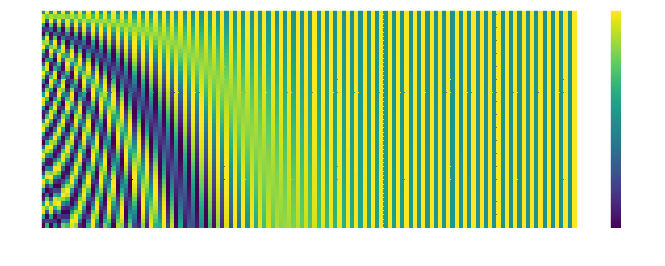

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
d_model = 128
max_sent_len = 50
positional_enc = PositionalEncoding(d_model).to(device)
data = torch.zeros(1, max_sent_len, d_model).to(device)
data_pos_enc = positional_enc.forward(data)
enc_np = data_pos_enc.squeeze(dim=0).to('cpu').numpy()
plt.figure(figsize=(12, 4))
plt.pcolormesh(enc_np, cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, d_model))
plt.ylim((max_sent_len, 0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

## The Transformer model

Now combine all the pieces to build the Transformer model

In [13]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads, input_dict_size, output_dict_size):
        super().__init__()
        self.max_sent_len = 50
        self.input_emb = nn.Embedding(input_dict_size, d_model)
        self.outp_emb = nn.Embedding(output_dict_size, d_model)
        self.positional_encoder = PositionalEncoding(d_model)
        self.encoder = Encoder(num_layers, d_model, num_att_heads)
        self.decoder = Decoder(num_layers, d_model, num_att_heads)
        self.outp_logits = nn.Linear(d_model, out_dict_size)
        self.softmax = nn.Softmax(dim=-1)

    def translate(self, src, tgt_start_code, tgt_eos_code, src_padding_mask, src_subsq_mask):
        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)
        snt = torch.ones((1,1,1)) * tgt_start_code
        snt = snt.long()
        snt = snt.to(device)
        translation_idxes = []
        for idx in range(self.max_sent_len):
            dec_x = self.outp_emb.forward(snt.squeeze(dim=2))
            dec_x = self.positional_encoder.forward(dec_x)
            dec_x = self.decoder.forward(
                dec_x,
                src_padding_mask = src_padding_mask,
                tgt_padding_mask = torch.zeros_like(snt).float().to(device),
                tgt_subsq_mask = get_square_subsequent_mask(snt.size()[1]),
                mem_keys = enc_keys,
                mem_values = enc_values)
            dec_x = self.outp_logits.forward(dec_x)
            dec_x = self.softmax(dec_x)
            next_word_softmax = dec_x[0,idx,:].to('cpu').detach()
            next_word_idx = torch.argmax(next_word_softmax)
            snt = torch.cat([snt, torch.ones((1,1,1)).long().to(device) * next_word_idx], dim=1)
            translation_idxes.append(next_word_idx)
            if next_word_idx == tgt_eos_code:
                break
        return translation_idxes

    def forward(self, src, tgt, src_padding_mask, src_subsq_mask, tgt_padding_mask, tgt_subsq_mask):
        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)
        dec_x = self.outp_emb.forward(tgt.squeeze(dim=2))
        dec_x = self.positional_encoder.forward(dec_x)
        dec_x = self.decoder.forward(
            dec_x,
            src_padding_mask=src_padding_mask,
            tgt_padding_mask=torch.zeros_like(tgt_padding_mask).float().to(device),
            tgt_subsq_mask=get_square_subsequent_mask(tgt_subsq_mask.size()[1]),
            mem_keys=enc_keys,
            mem_values=enc_values)
        dec_x = self.outp_logits.forward(dec_x)
        dec_x = self.softmax(dec_x)
        return dec_x


Now you have finished building the model. Just train now. The code is complete

### Some helper functions

In [14]:
def get_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len).to(device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def get_padding_mask(input, val1 = float('-inf'), val2 = float(0.0)):
    mask = torch.ones(input.size()).to(device)
    mask = mask.float().masked_fill(input == 0, val1).masked_fill(input > 0, val2)
    return mask

def get_one_hot(x, out_dim, mask):
    tens = x.view(-1)
    tens_one_hot = torch.zeros(list(tens.size()) + [out_dim]).to(device)
    for i in range(len(tens)):
        tens_one_hot[i,tens[i]] = 1
    tens_one_hot = tens_one_hot.view(list(x.size()) + [out_dim])
    tens_one_hot = tens_one_hot * mask
    return tens_one_hot.to(device)

In [15]:
#Prepare the sentence for model translate function
def translate_sentences(src_sentences, tgt_sentences, max_sent_num = 15):
    transformer_model.eval()
    with torch.no_grad():
        for snt_idx in range(len(src_sentences)):
            if snt_idx > max_sent_num:
                break
            src = src_sentences[snt_idx:snt_idx+1]
            padded_src = pad_sequence(src, padding_value=0, batch_first=True).to(device)
            src_padding_mask = get_padding_mask(padded_src)
            src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])
            snt_translation = transformer_model.translate(
                src = padded_src,
                tgt_start_code = dataset.get_eng_start_code(),
                tgt_eos_code = dataset.get_eng_eos_code(),
                src_padding_mask = src_padding_mask,
                src_subsq_mask = src_subsq_mask)
            src_sent = ''
            for word_idx in src_sentences[snt_idx]:
                src_sent = f"{src_sent} {dataset.fra_token_to_text[word_idx]}"
            tgt_sent = ''
            for word_idx in tgt_sentences[snt_idx]:
                tgt_sent = f"{tgt_sent} {dataset.eng_token_to_text[word_idx]}"
            translated_sent = ''
            for word_idx in snt_translation:
                translated_sent = f"{translated_sent} {dataset.eng_token_to_text[word_idx]}"
            print(f"Source sentence is: {src_sent}")
            print(f"Target sentence is: {tgt_sent}")
            print(f"Model translation is: {translated_sent}")
    transformer_model.train()

### Hyperparams, model definition and dataset

In [16]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 12
STORE_MODELS = True
models_path = 'models'

if not os.path.exists(models_path):
    os.mkdir(models_path)

dataset = FraEngDataset()  # size = 170,190
sentences_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=fra_eng_dataset_collate)
in_dict_size = dataset.get_fra_dict_size() 
out_dict_size = dataset.get_eng_dict_size()  
transformer_model = Transformer(
    num_layers=6,
    d_model=512,
    num_att_heads=8,
    input_dict_size=in_dict_size,  # size = 31,203
    output_dict_size=out_dict_size).to(device)   # size = 16,062
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE)

170190


# Training and sentence translation
Now just train the model. You should be able to see the translations at the end of each epoch. Check the quality of your translations. Be patient. Each epoch can take more than 2 hours in a GPU.

In [17]:
for epoch in range(EPOCHS):
    src_sentences = None
    tgt_sentences = None
    train_loss_sum = 0.0
    total_word_count = 0.0

    for sentences in sentences_loader:
        src_sentences = sentences['fra_sentences']
        tgt_sentences = sentences['eng_sentences']
        tgt_sentences_out = []
        for idx in range(len(tgt_sentences)):
            tgt_sentences_out.append(tgt_sentences[idx][1:])
            tgt_sentences[idx] = tgt_sentences[idx][:-1]

        # Create tensors from token lists
        padded_src = pad_sequence(src_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt = pad_sequence(tgt_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt_out = pad_sequence(tgt_sentences_out, padding_value=0, batch_first=True).to(device)
        src_padding_mask = get_padding_mask(padded_src)
        src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])
        tgt_padding_mask = get_padding_mask(padded_tgt)
        tgt_subsq_mask = get_square_subsequent_mask(padded_tgt.size()[1])

        pred = transformer_model.forward(
            src=padded_src,
            tgt=padded_tgt,
            src_padding_mask=src_padding_mask,
            src_subsq_mask=src_subsq_mask,
            tgt_padding_mask=tgt_padding_mask,
            tgt_subsq_mask=tgt_subsq_mask)

        # Mask to zero one hot vectors corresponding to padded elements
        one_hot_mask = get_padding_mask(padded_tgt_out, val1=float(0.0), val2=float(1.0))
        y_one_hot = get_one_hot(padded_tgt_out.squeeze(dim=2), out_dict_size, mask=one_hot_mask)
        loss = - torch.sum(torch.log(pred) * y_one_hot)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_sum += loss.detach().to('cpu').data
        total_word_count += torch.sum(y_one_hot).to('cpu').data

    print(f"Epoch {epoch} " + '=' * 60)
    print(f"Total loss per word: {train_loss_sum / total_word_count}")
    print(f"Some translated sentences:")
    with torch.no_grad():
     translate_sentences(src_sentences,tgt_sentences) # Take the last batch and translate some sentences.
    
    if STORE_MODELS == True:
        model_path = os.path.join(models_path, f'Epoch_{epoch}_model.pt')
        torch.save(transformer_model, model_path)

print("Training done! Generating some more sentences.")